# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: double pendulum

Consider a double pendulum with angles $\theta_1(t), \theta_2(t)$ and input $u(t)$. Using Lagrangian mechanics, we obtain the following equations of motion:

$$\begin{align} 
J_a \ddot{\theta}_1 + J_x \cos(\theta_1 - \theta_2)\ddot{\theta}_2 + J_x \sin(\theta_1 - \theta_2)\dot{\theta}_2^2 + \mu_1 \sin \theta_1 - K_t (\theta_2 - \theta_1) &= 0 \\
J_b \ddot{\theta}_2 + J_x \cos(\theta_1 - \theta_2)\ddot{\theta}_1 - J_x \sin(\theta_1 - \theta_2)\dot{\theta}_1^2 + \mu_2 \sin \theta_2 - K_t (\theta_2 - \theta_1) &= 0
\end{align}$$

where we've used the shorthand notation:

$$\begin{align}
J_a = \frac{1}{3}m_1 l_1^2 + m_2 l_1^2 \, , \quad
J_b = \frac{1}{3}m_2 l_2^2 \, , \quad
J_x = \frac{1}{2}m_2 l_1 l_2 \, , \quad
\mu_1 = (\frac{1}{2}m_1 + m_2)Gl_2 \, , \quad
\mu_2 = \frac{1}{2}m_2 G l_2 \, .
\end{align}$$

After some manipulation, we can express this as:

$$\begin{align} 
\dot{z} = \begin{bmatrix} z_3 \\ z_4 \\ M(z_1,z_2)^{-1} \begin{bmatrix} - J_x \sin(\theta_1 - \theta_2)\dot{\theta}_2^2 - \mu_1 \sin \theta_1 + K_t (\theta_2 - \theta_1) \\
 J_x \sin(\theta_1 - \theta_2)\dot{\theta}_1^2 - \mu_2 \sin \theta_2 + K_t (\theta_2 - \theta_1) \end{bmatrix} \end{bmatrix}
\end{align}$$

where $m$ is mass, $l$ is length, $\gamma$ is damping and $\mathcal{g}$ is Earth's gravity.

$$\begin{align}
M(\theta_1,\theta_2)^{-1} = \frac{1}{J_a J_b - J_x^2 \cos(\theta_1 - \theta_2)^2} \begin{bmatrix} J_b & -J_x \cos(\theta_1 - \theta_2) \\ -J_x \cos(\theta_1 - \theta_2) & J_a \end{bmatrix}
\end{align}$$

In [1]:
using Revise
using ForwardDiff
using Optim
using RxInfer
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3,margin=20Plots.pt)

includet("../NARXAgents.jl"); using .NARXAgents
includet("./Pendulums.jl"); using .Pendulums

In [2]:
# System parameters
sys_mass = [1.0, 2.0]
sys_length = [1.0, 1.0]
sys_damping = 0.0
sys_mnoise_S = 1e-2*diagm(ones(2))

2×2 Matrix{Float64}:
 0.01  0.0
 0.0   0.01

In [3]:
N = 200
Δt = 0.05
tsteps = range(0.0, step=Δt, length=N)

0.0:0.05:9.95

In [4]:
# Inputs
A  = rand(10)*200 .- 100
Ω  = rand(10)*3
controls = transpose([rand(N) mean([A[i]*sin.(Ω[i].*tsteps) for i = 1:10])./5])

2×200 transpose(::Matrix{Float64}) with eltype Float64:
 0.580596   0.892622   0.976723   0.336668  …   0.843356   0.5067    0.248932
 0.0       -0.376803  -0.750701  -1.11882      -4.95694   -4.91727  -4.85139

In [5]:
init_state = [0.0, 0.0, 0.0, 0.0]
pendulum = DPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_S = sys_mnoise_S, 
                     Δt=Δt)

states = zeros(4,N)
observations = zeros(2,N)

for k in 1:N
    states[:,k] = pendulum.state
    observations[:,k] = pendulum.sensor
    step!(pendulum, controls[:,k])
end

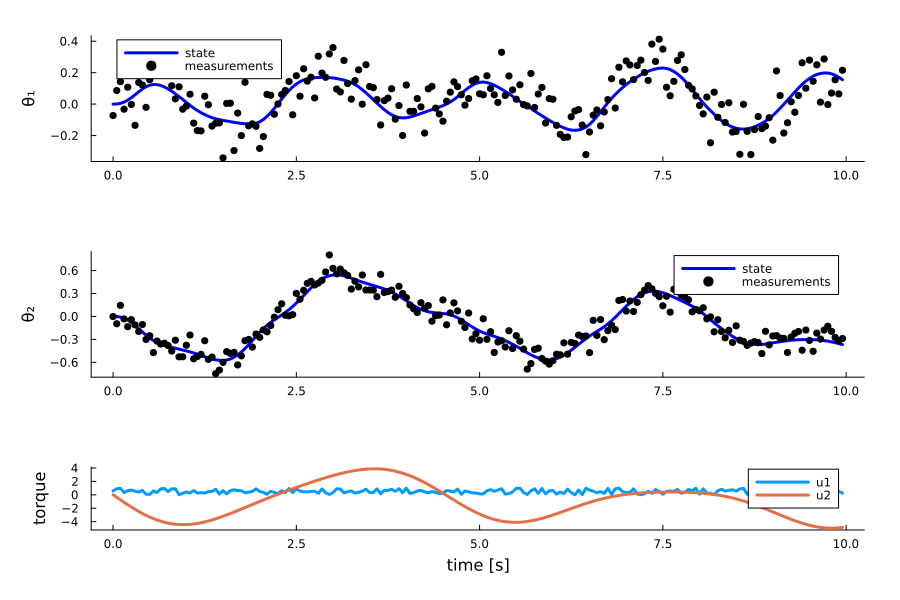

In [6]:
p101 = plot(ylabel="θ₁")
plot!(tsteps, states[1,:], color="blue", label="state")
scatter!(tsteps, observations[1,:], color="black", label="measurements")
p102 = plot(ylabel="θ₂")
plot!(tsteps, states[2,:], color="blue", label="state")
scatter!(tsteps, observations[2,:], color="black", label="measurements")
p103 = plot(xlabel="time [s]", ylabel="torque")
plot!(tsteps, controls', labels=["u1" "u2"])
plot(p101,p102,p103, layout=grid(3,1, heights=[0.4, 0.4, 0.2]), size=(900,600))

In [7]:
savefig("figures/NARX-EFE-2Pendulum-simulation.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-EFE-2Pendulum-simulation.png"

## NARX model

In [8]:
# Polynomial degree
H = 1

# Delay order
Ly = 3
Lu = 3

# Model order
M = size(ϕ(zeros(Ly+Lu), degree=H),1);

In [9]:
# Specify prior distributions
pτ0 = GammaShapeRate(1e0, 1e0)
pθ0 = MvNormalMeanCovariance(ones(M), 100diagm(ones(M)))

MvNormalMeanCovariance(
μ: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Σ: [100.0 0.0 … 0.0 0.0; 0.0 100.0 … 0.0 0.0; … ; 0.0 0.0 … 100.0 0.0; 0.0 0.0 … 0.0 100.0]
)


In [10]:
agent = NARXAgent(pθ0, pτ0, memory_actions=Lu, memory_senses=Ly, pol_degree=H)

NARXAgent(FactorGraphModel(), Constraints:
  marginals form:
  messages form:
  factorisation:
    q(θ, τ) = q(θ)q(τ)
Options:
  warn = true
, [Inf], MvNormalMeanCovariance(
μ: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Σ: [100.0 0.0 … 0.0 0.0; 0.0 100.0 … 0.0 0.0; … ; 0.0 0.0 … 100.0 0.0; 0.0 0.0 … 0.0 100.0]
)
, GammaShapeRate{Float64}(a=1.0, b=1.0), NormalMeanVariance{Float64}(μ=0.0, v=1.0), 1, 10, 1.0, 3, 3, 1, 7, [0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

## Parameter estimation

In [11]:
py = []
qθ = [pθ0]
qτ = [pτ0]
FE = zeros(10,N)

T = 1
@showprogress for k in 1:N
    
    # Make predictions
    push!(py, predictions(agent, [controls[2,k]], time_horizon=T))
    
    # Update beliefs
    NARXAgents.update!(agent, observations[2,k], controls[2,k])
    FE[:,k] = agent.free_energy
    
    push!(qθ, agent.qθ)
    push!(qτ, agent.qτ)

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


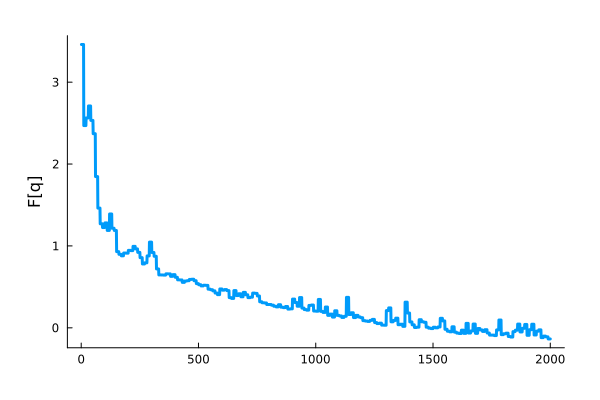

In [12]:
plot(FE[:], ylabel="F[q]")

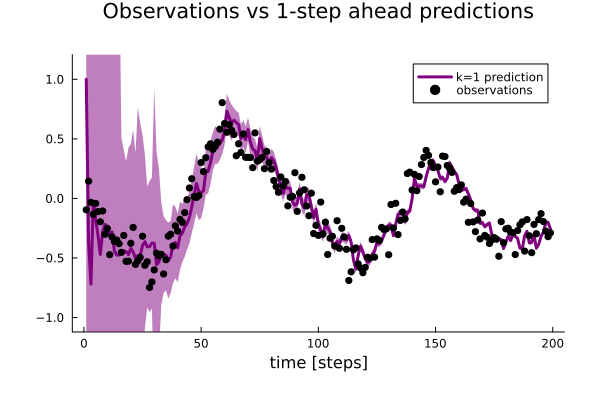

In [13]:
limsb = [minimum(observations[:])*1.5, maximum(observations[:])*1.5]
K = 1

p1 = plot(xlabel="time [steps]", title="Observations vs $T-step ahead predictions", ylims=limsb)
plot!([mean(py[k][K]) for k in 1:(N-T)], ribbon=[var(py[k][K]) for k in 1:(N-T)], color="purple", label="k=$K prediction")
scatter!(observations[2,2:end], color="black", label="observations")

## Control experiments

In [ ]:
# Length of trial
N = 150
tsteps = range(0.0, step=Δt, length=N)
T = 3

# Set control properties
goal1 = NormalMeanVariance(3.14, 1e-4)
goal2 = NormalMeanVariance(3.14, 1e-4)
control_prior = 1e-2
num_iters = 10
u_lims = (-100, 100)

# Polynomial degree
H = 1

# Delay order
Ly = 3
Lu = 3

# Model order
M = size(ϕ(zeros(Ly+Lu), degree=H),1);

# Specify prior distributions
pτ0 = GammaShapeRate(1e0, 1e-1)
pθ0 = MvNormalMeanCovariance(ones(M), 10diagm(ones(M)))

init_state = [0.0, 0.0];

### Mean Squared Error

In [ ]:
# Initialize beliefs
pτ = [pτ0]
pθ = [pθ0]

# Start system
init_state = [0.0, 0.0, 0.0, 0.0]
pendulum = DPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_S = sys_mnoise_S, 
                     Δt=Δt)

# Start agents
agent1 = NARXAgent(pθ0, pτ0, 
                   goal_prior=goal1, 
                   memory_actions=Lu, 
                   memory_senses=Ly, 
                   pol_degree=H,
                   thorizon=T,
                   control_prior=control_prior,
                   num_iters=num_iters)
agent2 = NARXAgent(pθ0, pτ0, 
                   goal_prior=goal1, 
                   memory_actions=Lu, 
                   memory_senses=Ly, 
                   pol_degree=H,
                   thorizon=T,
                   control_prior=control_prior,
                   num_iters=num_iters)

# Preallocate
y_ = zeros(N)
u_ = zeros(N+1)

pred_m = zeros(N,T)
pred_v = zeros(N,T)
FE = zeros(num_iters, N)

@showprogress for k in 1:N
    
    # Act upon environment
    step!(pendulum, [0.0; u_[k]])
    y_[k] = pendulum.sensor[2]
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_[k], u_[k])
    
    FE[:,k] = agent.free_energy
    push!(pθ, agent.qθ)
    push!(pτ, agent.qτ)
    
    # Optimal control
    policy = minimizeEFE(agent, time_limit=tlimit, control_lims=u_lims)
    u_[k+1] = policy[1]
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)
    
end

### Expected Free Energy minimization

In [37]:
# Length of trial
N = 150
tsteps = range(0.0, step=Δt, length=N)
T = 3

# Set control properties
goal = NormalMeanVariance(3.14, 1e-4)
control_prior = 1e-2
num_iters = 10
u_lims = (-100, 100)

# Initialize beliefs
pτ = [pτ0]
pθ = [pθ0]

# Start system
init_state = [0.0, 0.0, 0.0, 0.0]
pendulum = DPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_S = sys_mnoise_S, 
                     Δt=Δt)

# Start agent
agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  memory_actions=Lu, 
                  memory_senses=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=control_prior,
                  num_iters=num_iters)

# Preallocate
y_ = zeros(N)
u_ = zeros(N+1)

pred_m = zeros(N,T)
pred_v = zeros(N,T)
FE = zeros(num_iters, N)

@showprogress for k in 1:N
    
    # Act upon environment
    step!(pendulum, [0.0; u_[k]])
    y_[k] = pendulum.sensor[2]
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_[k], u_[k])
    
    FE[:,k] = agent.free_energy
    push!(pθ, agent.qθ)
    push!(pτ, agent.qτ)
    
    # Optimal control
    policy = minimizeEFE(agent, time_limit=tlimit, control_lims=u_lims)
    u_[k+1] = policy[1]
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)
    
end

LoadError: UndefVarError: `tlimit` not defined

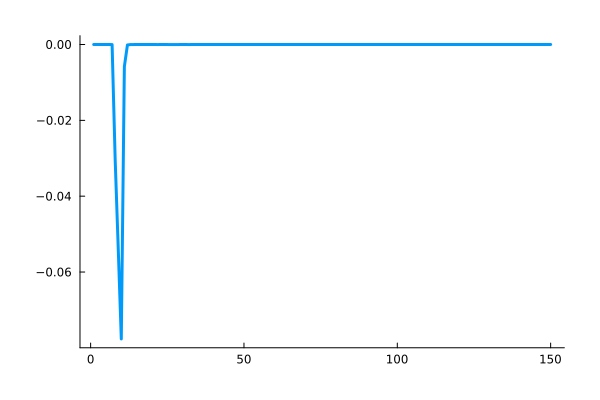

In [14]:
plot(FE[end,:] .- FE[1,:])

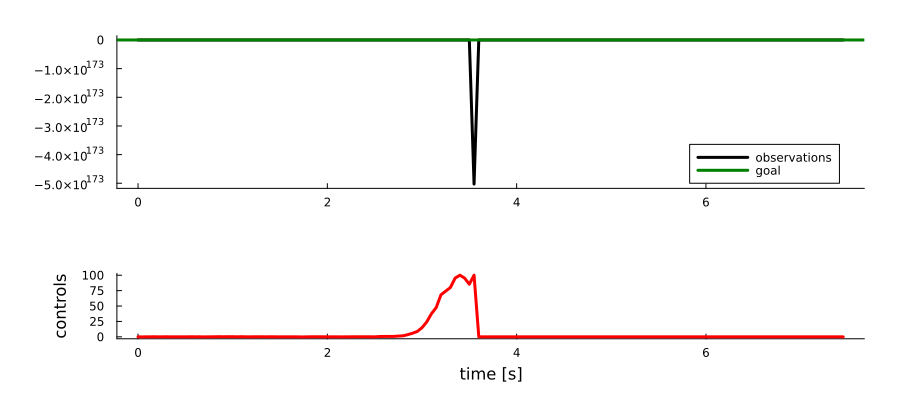

In [80]:
p1 = plot(tsteps, y_, color="black", label="observations")
hline!([mean(goal)], color="green", label="goal",)
p4 = plot(tsteps, u_[1:end-1], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [16]:
savefig("figures/NARX-EFE-1Pendulum-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-EFE-1Pendulum-trial.png"

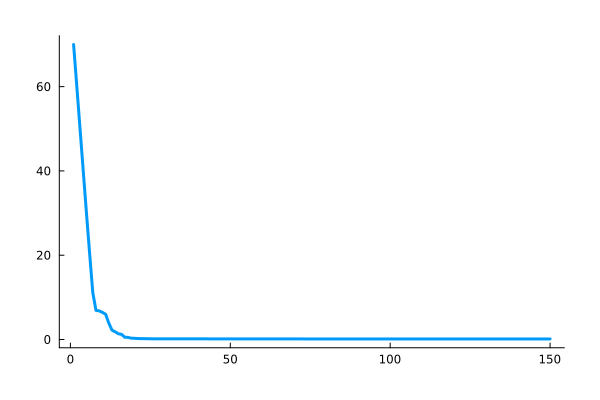

In [17]:
tSθ = [tr(cov(pθ[k])) for k in 1:N]
plot(tSθ)

In [18]:
limsb = [minimum(y_)*1.5, maximum(y_)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    else
        plot(tsteps[k-window:k], y_[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    end
    
end
gif(anim, "figures/NARX-EFE-1Pendulum-planning.gif", fps=24)

LoadError: UndefVarError: `m_star` not defined